In [1]:
# Imports and setup
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load data
connections = pd.read_csv("data/connections_princeton_no_threshold.csv.gz")
cell_types = pd.read_csv("data/consolidated_cell_types.csv.gz")

threshold = 3

# Apply minimum synapse filter (threshold = 3)
connections = connections[connections['syn_count'] >= threshold]

print(connections.head())
print(f"Remaining connections: {len(connections)}")

           pre_root_id        post_root_id neuropil  syn_count nt_type
0   720575940625363947  720575940623224444     ME_L         12    GABA
2   720575940630432382  720575940618518557     ME_L         67     ACH
3   720575940627314521  720575940626337738     ME_L         10    GABA
7   720575940620280405  720575940620204726     ME_L         15     ACH
14  720575940608359298  720575940613493733     ME_L          5     ACH
Remaining connections: 6857111


In [3]:
# Plotting functions

def plot_primacy_distribution(df, target_label, max_rank=5):
    """
    Stacked bar plot of primacy distribution (strong vs weak inputs).
    """
    counts = (
        df.groupby(['rank', 'strength'])
          .size()
          .unstack(fill_value=0)
          .reindex(range(1, max_rank+1), fill_value=0)
    )

    counts.plot(kind='bar', stacked=True, color={'strong':'darkgreen', 'weak':'lightgreen'})
    plt.xlabel("Primacy rank of target neuron")
    plt.ylabel("Number of presynaptic cell types")
    plt.title(f"Input primacy distribution for {target_label}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [4]:
# Utility functions
def get_inputs(connections, target_id):
    """
    Return all presynaptic neurons (and their synapse counts) that connect to the target neuron.
    """
    return connections[connections['post_root_id'] == target_id][['pre_root_id', 'syn_count']]

def get_outputs(connections, target_id):
    """
    Return all outputs (postsynaptic partners and synapse counts) of a given neuron.
    """
    return connections[connections['pre_root_id'] == target_id][['post_root_id', 'syn_count']]

def compute_primacy_by_type(
    connections,
    target_id,
    cell_types,
    strong_threshold=100,
    min_syn_count=3,
    verbose=False,
    show_progress=True
):
    """
    For a target neuron, compute primacy ranking across its input CELL TYPES.

    Steps:
    - Collapse inputs to the target by presynaptic cell type.
    - For each input type, fetch all outputs (by type), collapse by type, rank the target.
    - Return DataFrame of input types with weight_to_target, rank, and strength.

    Returns: DataFrame with columns
      input_type, weight_to_target, rank, strength
    """
    # filter at the very beginning
    conn_filt = connections[connections['syn_count'] >= min_syn_count]

    # map neuron IDs → primary_type
    id_to_type = dict(zip(cell_types['root_id'], cell_types['primary_type']))

    # --- Step 1: collapse inputs by type ---
    inputs = (
        conn_filt[conn_filt['post_root_id'] == target_id]
        .assign(type_pre=lambda df: df['pre_root_id'].map(id_to_type))
        .dropna(subset=['type_pre'])
        .groupby('type_pre', as_index=False)['syn_count'].sum()
        .rename(columns={'syn_count': 'weight_to_target'})
        .sort_values('weight_to_target', ascending=False, ignore_index=True)
    )

    primacy_records = []

    # --- Step 2: for each input TYPE, compute rank of target among its outputs ---
    iterator = inputs.iterrows()
    if show_progress:
        iterator = tqdm(inputs.iterrows(), total=len(inputs), desc=f"Analyzing {len(inputs)} input types")
    for _, row in iterator:
        in_type = row['type_pre']

        # all neurons of this type
        members = cell_types.loc[cell_types['primary_type'] == in_type, 'root_id']

        outputs = (
            conn_filt[conn_filt['pre_root_id'].isin(members)]
            .assign(type_post=lambda df: df['post_root_id'].map(id_to_type))
            .dropna(subset=['type_post'])
            .groupby('type_post', as_index=False)['syn_count'].sum()
            .sort_values('syn_count', ascending=False, ignore_index=True)
        )

        # find target type (e.g. "oviIN") in outputs
        target_type = cell_types.loc[cell_types['root_id'] == target_id, 'primary_type'].values[0]
        mask = outputs['type_post'] == target_type

        if mask.any():
            pos = outputs.index[mask][0]
            rank = pos + 1
            out_weight = outputs.loc[mask, 'syn_count'].values[0]

            primacy_records.append({
                'input_type': in_type,
                'weight_to_target_type': out_weight,
                'rank': rank,
                'strength': 'strong' if out_weight >= strong_threshold else 'weak'
            })
        elif verbose:
            print(f"Input type {in_type} → target type {target_type}: not found")

    return pd.DataFrame(primacy_records)


Analyzing 229 input types: 100%|██████████| 229/229 [00:27<00:00,  8.25it/s]


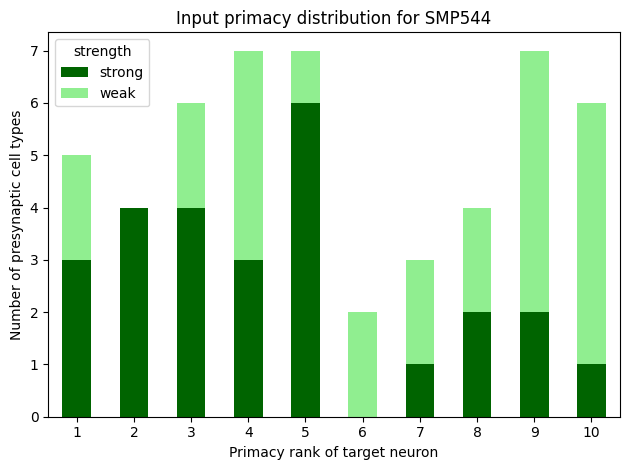

In [5]:
target_id = 720575940633705636
target_label = "SMP544"

primacy_df = compute_primacy_by_type(
    connections,
    target_id,
    cell_types=cell_types,
    strong_threshold=100,
    min_syn_count=threshold
)

plot_primacy_distribution(primacy_df, target_label, max_rank=10)